# MNIST Digit Recognizer Dimensionality Reduction

This is my third swipe at the MNIST digit classification exercise.  My first attempt, with a random forest approach, yielded ~96% accuracy max.  My second, where I tried tweaking all of the hyperparameters in a simple neural network, showed little to no improvement over this score.  Now I'd like to try a third approach that I've seen on Kaggle: that of performing dimensionality reduction of the dataset with PCA or LDA, followed by explicit classification by a support vector machine or K-means clustering.

The general steps to perform PCA and LDA are inspired by Anisotropic's thorough [notebook](https://www.kaggle.com/arthurtok/digit-recognizer/interactive-intro-to-dimensionality-reduction).

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from time import clock
import random
import itertools as it
from sklearn import model_selection, svm
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
matplotlib.style.use('ggplot')
%matplotlib inline

In [61]:
%%time

# on the PC:
train = pd.read_csv('C:\\Users\\DMacKellar\\Documents\\Python\\Kaggle\\Digit\\train.csv')

test = pd.read_csv('C:\\Users\\DMacKellar\\Documents\\Python\\Kaggle\\Digit\\test.csv')

# on the Mac:
# train = pd.read_csv('/Users/drew/Documents/Data/R/Kaggle_Digit_Recognizer/train.csv')

# test = pd.read_csv('/Users/drew/Documents/Data/R/Kaggle_Digit_Recognizer/test.csv')

Wall time: 5.96 s


## Part 1: Rescale the data

When working with the neural networks, I came across the importance of rescaling/normalizing the data set, to ease handling of it by downstream processing.  It [appears sensible](http://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-analysis) that the same applies before attempting dimensionality reduction, as well.  In the interest of varying the approach, however, I'll use sklearn's preprocessing module, instead of the lambda function I used in the neural network notebook.  I've seen StandardScaler used, but according to the [docs](http://scikit-learn.org/stable/modules/preprocessing.html#scaling-sparse-data), that may not be the most appropriate approach for a sparse data set, which is clearly what we have:

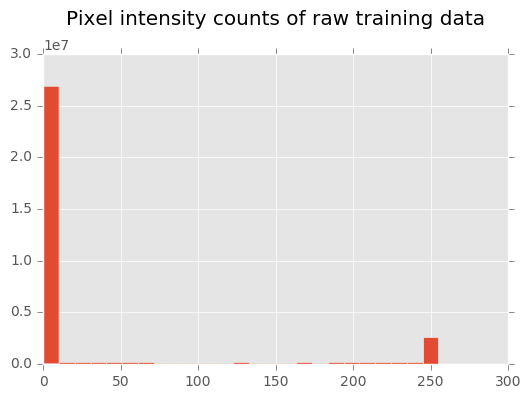

In [62]:
train.iloc[:,1:].stack().hist(bins=25)
plt.title('Pixel intensity counts of raw training data\n')
plt.show()

Instead, I'll use MaxAbsScaler:

In [63]:
train2 = MaxAbsScaler().fit_transform(train.iloc[:,1:].values)
train3 = pd.DataFrame(data=train2, index=train.index, columns=train.columns[1:])
train4 = pd.concat([train.iloc[:,0], train3], axis=1, join='inner')
train4.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


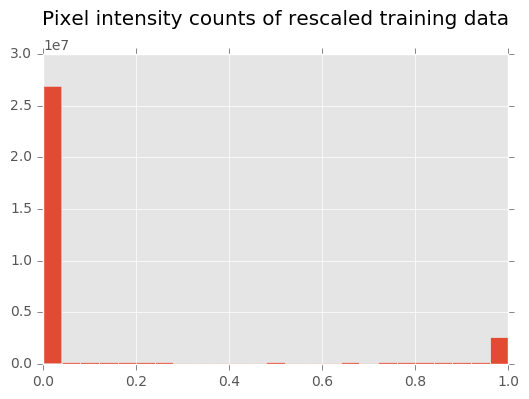

In [6]:
train4.iloc[:,1:].stack().hist(bins=25)
plt.title('Pixel intensity counts of rescaled training data\n')
plt.show()

And to rescale the test data:

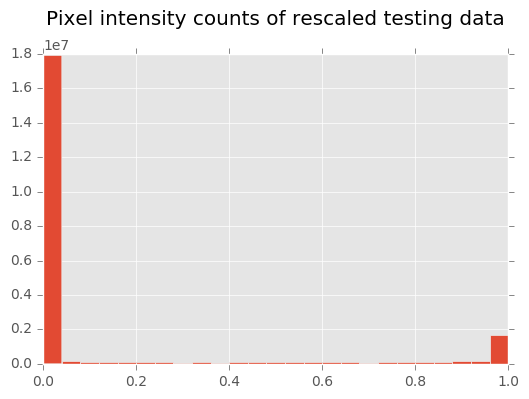

In [91]:
test2 = MaxAbsScaler().fit_transform(test.values)
test3 = pd.DataFrame(data=test2, index=test.index, columns=test.columns)

test3.stack().hist(bins=25)
plt.title('Pixel intensity counts of rescaled testing data\n')
plt.show()

## Part 2: How many components to try?

I'll try both PCA and LDA, but a crucial question is the number of components to include.  One website that I found offered [some guidelines](https://jalt.org/test/bro_30.htm), and I'm tempted to try to make a scree plot.  By calling PCA from sklearn with defaults, it will use the number of features in the DataFrame as the number of components to output, and their eigenvalues will be the same as the property explained\_variance\_ for each component.

As I'm a little unfamiliar with this property, however, I'd like to try calculating eigenvalues in two different ways (via sklearn and numpy):

In [8]:
# calculating eigenvectors for the rescaled data
X = train3
n_samples = X.shape[0]

pca = PCA()
X_transformed = pca.fit_transform(X)

# center the data and compute covariance matrix
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
eigenvalues = pca.explained_variance_
numpy_eigs = np.linalg.eigvals(cov_matrix)

# for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
#     print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)), '\t', eigenvalue)

C:\Python\lib\site-packages\numpy\core\numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


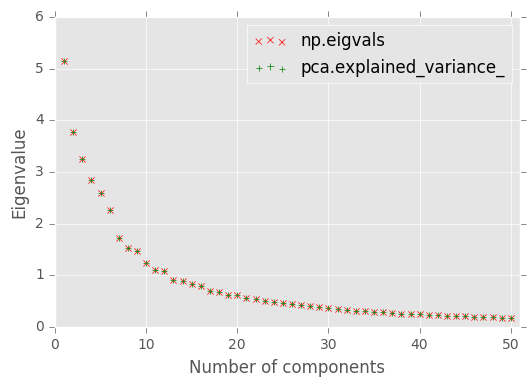

In [85]:
plt.scatter(range(1, 51), numpy_eigs[0:50], color='r', marker='x', label='np.eigvals')
plt.scatter(range(1, 51), eigenvalues[0:50], color='g', marker='+', label='pca.explained_variance_')
plt.axis([0, 51, 0, 6])
plt.xlabel('Number of components')
plt.ylabel('Eigenvalue')
plt.legend(loc=1)
plt.show()

Ok, I'm satisfied that these approaches are measuring the same thing.  There's no sharp inflection point discernable by eye in the scree plot, but I'd say that around 10 components (eigenvalue ~1) is a good cutoff to try.  I understand, however, that it's also common to compare the individual variance in the data captured or explained by each individual principal component, alongside the cumulative variance captured by the first *n* components:

In [86]:
totals = sum(eigenvalues)
var_exp = [(i / totals)*100 for i in sorted(eigenvalues, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

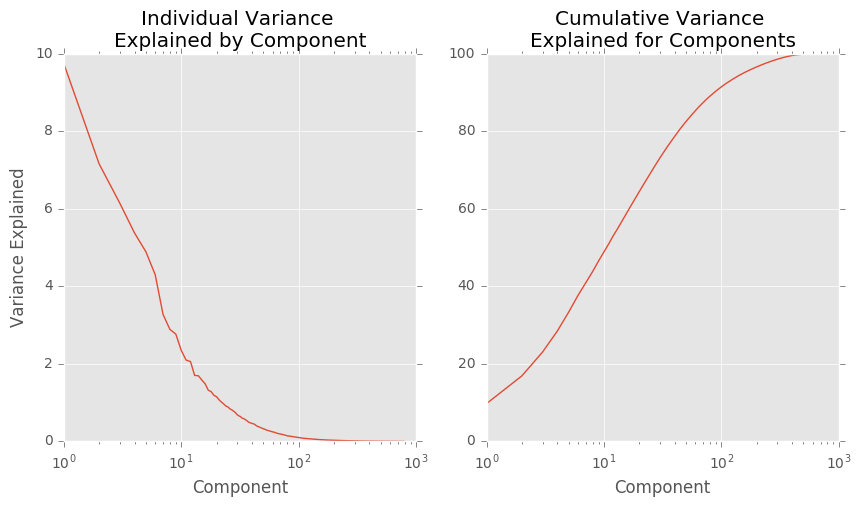

In [85]:
fig = plt.figure(figsize=(10, 5))

plt1 = fig.add_subplot(121)
plt1.plot(range(1, 785), var_exp)
plt1.set_title('Individual Variance \nExplained by Component')
plt1.set_xscale('log')
plt1.set_xlabel('Component')
plt1.set_ylabel('Variance Explained')

plt2 = fig.add_subplot(122)
plt2.plot(range(1, 785), cum_var_exp)
plt2.set_xscale('log')
plt2.set_xlabel('Component')
plt2.set_title('Cumulative Variance \nExplained for Components')
plt.show()

Of course, using log scale on the X axis isn't the most natural way of viewing the variance, but it's tough to visualize in a single plot otherwise.  So the individual variance definitely does start to drop off after about 10 components, but the cumulative variance after 10 components is only around 50%.  This data set is not one in which a couple of components explain the vast majority of the variance.  It may very well be sensible to try other values, but for the sake of exploration, I'll just proceed with 10.

## Part 3: PCA & LDA

As a function, PCA doesn't have as many knobs to tweak as, say, the MLPClassifier from sklearn that I utilized in the previous approach.

In [17]:
%%time

pca = PCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)

CPU times: user 6.62 s, sys: 1.02 s, total: 7.64 s
Wall time: 5.17 s


Take a look at a few of the values manually, to get a sense of what the principal components look like:

In [47]:
print(type(X), type(X_pca))
print(X.shape, X_pca.shape)
for i in range(10):
    print(X.iloc[i, 0:5].values, '\t', X_pca[i])

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
(42000, 784) (42000, 10)
[ 0.  0.  0.  0.  0.] 	 [-2.59449323 -2.74239726  0.71875277  0.47298573 -0.31796899  1.91946537
 -2.68033466  0.33551343  1.3668938   0.79544684]
[ 0.  0.  0.  0.  0.] 	 [ 6.67235953 -1.41392751 -1.9678644   1.31538581 -1.73481766  2.89568209
  2.56435853 -0.69243485 -0.0295673   0.26709309]
[ 0.  0.  0.  0.  0.] 	 [-3.47801735 -1.15202262  0.26335412  0.30691753 -1.85771185 -1.26878436
  1.71678926 -1.19748076 -0.76545679 -0.10073384]
[ 0.  0.  0.  0.  0.] 	 [-0.6500219   1.17718752 -0.25154921  2.97924202 -1.66998259  0.61720886
 -1.19260892  1.08408182 -0.17945172 -1.15850908]
[ 0.  0.  0.  0.  0.] 	 [ 7.54395962 -1.76138439 -2.15142363  0.73942981 -2.55582595  3.88259393
  2.21390399 -1.00357776  0.48956081  0.69756574]
[ 0.  0.  0.  0.  0.] 	 [ 1.91275258  0.75589182 -0.02523911 -0.16022339 -0.1853383   0.27620544
 -0.6578118   1.44410218 -2.78649398 -0.56790965]
[ 0.  0.  0.  0.  0.] 	 [-2.636

And a quick look at the first two principal components:

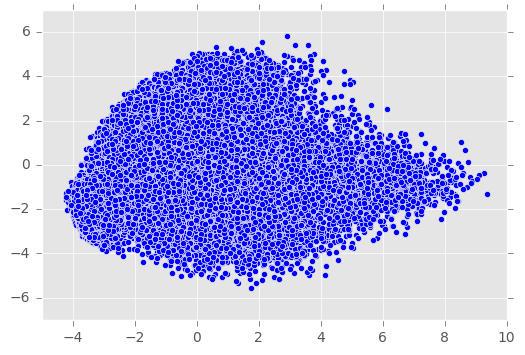

In [63]:
plt.scatter(X_pca[:,0], X_pca[:, 1])
plt.axis([-5, 10, -7, 7])
plt.show()

Hmm... yeah, still very much a rounded cloud; but it has the sort of comet-like appearance of other data sets I've seen when viewed through their first couple principal components.  Next, I'll check the output of LDA with the same number of components.  

While the conceptual underpinnings of LDA are a newer to me, I appreciate the [gist](https://youtu.be/6Ht-nIf_NKc?list=PLBv09BD7ez_5_yapAg86Od6JeeypkS4YM&t=241) of it as a technique for dimensionality reduction while utilizing the label data.

Since this method is supervised, I'll revert to using train4, the pandas DataFrame containing the rescaled data associated with their labels.  Further, unlike PCA, the maximum number of components is "Number of components (< n_classes - 1) for dimensionality reduction", so the max is 9, not 10:

In [6]:
%%time

lda = LDA(n_components=10)
X_lda = lda.fit_transform(train4.iloc[:, 1:], train4.iloc[:, 0])

/Users/drew/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CPU times: user 35.9 s, sys: 3.03 s, total: 38.9 s
Wall time: 25.9 s


That returns a "UserWarning: Variables are collinear."  Not surprising; the features in this data set are certainly not all linearly independent.  Again, check a handful of the values to see their characteristics:

In [91]:
print(type(X_lda))
print(X_lda.shape)
print(X_lda[1:5, :])

<class 'numpy.ndarray'>
(42000, 9)
[[-4.75337332 -3.25709265 -2.983682   -1.24400102 -1.88093394 -0.89856411
   0.11441364 -1.09740898  1.23579005]
 [ 0.42647458  5.16870653 -0.21502815  0.24889477 -3.73780782  0.16890277
   0.54686681  0.16405815 -0.31479823]
 [-0.97841007 -0.55550256  1.14794527 -0.32452764 -0.99756828 -0.85839002
   0.97949726  1.84604388 -0.20796284]
 [-4.87818395 -3.24436699 -4.7238761  -0.85004569 -1.92317726 -2.09358678
   0.16672396 -2.22855446  0.99932801]]


As the output of LDA can technically be applied as a classification method by itself, I'll check the training accuracy:

In [8]:
%%time

score1 = lda.score(train4.iloc[:, 1:], train4.iloc[:, 0])
print(score1)

0.875214285714
Wall time: 257 ms


Hmm... 87.5%; not great by itself.  We'll see if this output will help as an input to further classification schemes.  First, graph the first couple linear discriminants:

In [7]:
lda_labels_x = {}
lda_labels_y = {}

for i, j in enumerate(train4.iloc[:500, 0].values):
    lda_labels_x.setdefault(j, []).append(X_lda[i, 0])
    lda_labels_y.setdefault(j, []).append(X_lda[i, 1])

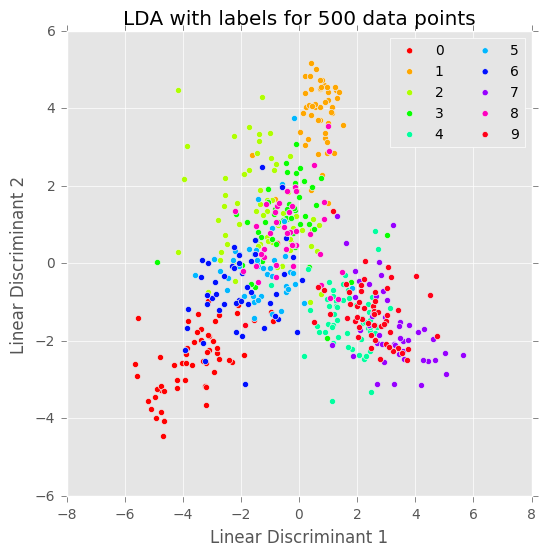

In [14]:
from matplotlib.cm import get_cmap
cmap = get_cmap("hsv", 10)

plt.figure(figsize=(6, 6))
for i in range(10):
    plt.scatter(lda_labels_x[i], lda_labels_y[i], c=cmap(i), label=i)

plt.legend(scatterpoints=1, loc='best', ncol=2, fontsize=10)
plt.title('LDA with labels for 500 data points')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.show()

Ok, not too bad; there's definite spatial separation, at least among some of the categories.

## Part 4: KNN

I'll try sklearn's K Nearest Neighbors algorithm as a first-pass at classification with the reduced datasets.  As per my notebook on MLPClassifier, I'll try it in conjunction with RandomizedSearchCV.  But first, just the default parameters:

In [18]:
%%time

knn = KNeighborsClassifier()
knn2 = cross_val_score(knn, X_pca, train4.iloc[:, 0].values, cv=10, n_jobs=-1)

CPU times: user 300 ms, sys: 169 ms, total: 469 ms
Wall time: 9.65 s


In [15]:
print(type(X_pca), type(train4.iloc[:, 0].values))
print(X_pca.shape, train4.iloc[:, 0].values.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(42000, 10) (42000,)


In [10]:
print(np.mean(knn2))

0.925000598032


Ok, so with default values, K-nearest neighbors on the dataset with 10 principal components returns an average of 92.5% accuracy.  The main parameters to try changing (other than the number of principal components, which I can try later) are the n_neighbors, [weights](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification), algorithm, and [leaf size](http://scikit-learn.org/stable/modules/neighbors.html#effect-of-leaf-size).

In [19]:
n_neighbors = list(range(2, 32, 2))
weights = ['uniform', 'distance']
param_distributions = dict(n_neighbors=n_neighbors, weights=weights)
rs_cv = RandomizedSearchCV(knn, param_distributions=param_distributions, n_iter=10, n_jobs=-1, cv=10)

I might expect this to take about 10x as long as the above, default run of knn (around 1 min on my laptop)

In [20]:
%%time

knn3 = rs_cv.fit(X_pca, train4.iloc[:, 0].values)

CPU times: user 2.59 s, sys: 673 ms, total: 3.27 s
Wall time: 23min 26s


In [21]:
print(knn3.best_params_, '\n', knn3.best_score_, '\n', knn3.best_estimator_)

{'n_neighbors': 6, 'weights': 'distance'} 
 0.92730952381 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')


Well, that DID take over 10 min for me, but I had miscalculated; the original (cross-validation with cv=10) ran in about 6 seconds, so I'm unsure why it took 10 min, rather than 10 * 6 sec, or 1 min.  Apparently running RandomizedSearchCV isn't just a simple linear scalar of the cross-validation run time.

Anyways, that only improved the score by an average of 0.2%.  Clearly, the number of neighbors or weights don't make a huge diff compared to the default params.  Given the very slight improvement, I might expect that none of these values changed the final score all that much:

In [22]:
knn3_results = pd.DataFrame.from_dict(data=knn3.cv_results_)
print(knn3_results['mean_test_score'])

0    0.925310
1    0.925143
2    0.924881
3    0.922000
4    0.923881
5    0.920571
6    0.924667
7    0.927143
8    0.919000
9    0.927310
Name: mean_test_score, dtype: float64


Yeah; no big diff over that range.  Oh well; it's probably not worth optimizing these values with this particular approach.  I'll re-run the default and comparison with the LDA-reduced data.

In [18]:
%%time

knn = KNeighborsClassifier()
knn4 = cross_val_score(knn, X_lda, train4.iloc[:, 0].values, cv=10, n_jobs=-1)

Wall time: 5.93 s


In [19]:
print(np.mean(knn4))

0.91842944929


Hmm... the LDA dataset fared slightly worse with default values on KNN.  I'll try checking the same range of n_neighbors and weights as before:

In [20]:
%%time

knn4 = rs_cv.fit(X_lda, train4.iloc[:, 0].values)

Wall time: 8min 12s


In [21]:
print(knn4.best_params_, '\n', knn4.best_score_, '\n', knn4.best_estimator_)

{'weights': 'uniform', 'n_neighbors': 12} 
 0.919571428571 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')


In [51]:
knn4_results = pd.DataFrame.from_dict(data=knn4.cv_results_)
print(knn4_results['mean_test_score'])

0    0.918024
1    0.900905
2    0.918119
3    0.916000
4    0.919214
5    0.917452
6    0.917643
7    0.918595
8    0.914881
9    0.919571
Name: mean_test_score, dtype: float64


Ok, the best accuracy for this walk through the knn parameter space with the LDA data set also returned a lower accuracy than did the PCA data set.  The difference certainly isn't drastic; around 1%.

## Part 5: SVM

Now I'd like to try feeding the reduced-dimensionality dataset through another common classifier used with the MNIST digits: that of a support vector machine.  The general idea with SVMs is just to identify a hyperplane that best separates the observed data into classes.

In [55]:
%%time

svc = svm.SVC()
svc1 = cross_val_score(svc, X_pca, train4.iloc[:, 0].values, cv=10, n_jobs=-1)

Wall time: 1min 29s


In [54]:
print(np.mean(svc1))

0.94171380513


Interesting; 94% with default parameters.  That's better than I saw with KNN.  I wonder how it will do with the linear discriminants, instead.

In [59]:
%%time

svc = svm.SVC(cache_size=1000)
svc2 = cross_val_score(svc, X_lda, train4.iloc[:, 0].values, cv=10, n_jobs=-1)

Wall time: 1min 9s


In [58]:
print(np.mean(svc2))
print(svc)

0.926237901056
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Huh.  Once again: a lower score with LDA, indicating it may be less favorable an option for reducing dimensionality of this data set than PCA, at least with the factors I've tried.

Support Vector Machines are more complicated than running K-nearest neighbors, it seems, and they have more hyperparameters that you can tweak.  Given the much longer runtime they have, I'll limit myself to testing just a few, starting C, which is [described as with the penalty parameter of the error](http://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).  This is a float between 0 and 1, and the default is 1, which is reported as being perhaps a little harsh on datasets with much noise in them.  The use of dimensionality reduction should have reduced this, but it's still worth playing with this value briefly.

In [62]:
Cs = list(np.linspace(0.1, 1, num=5))
param_grid = dict(C=Cs)
gs_cv = GridSearchCV(svc, cv=10, n_jobs=-1, param_grid=param_grid)

In [63]:
%%time

svc4 = gs_cv.fit(X_lda, train4.iloc[:, 0].values)

Wall time: 11min 45s


In [65]:
print(svc4.best_params_, '\n', svc4.best_score_, '\n', svc4.best_estimator_)

{'C': 1.0} 
 0.926238095238 
 SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Ok; the default of C=1 is still the best.  Another important factor is the choice of [kernel](http://scikit-learn.org/stable/modules/svm.html#svm-kernels) used.

In [73]:
%%time

kernels = ['rbf', 'linear', 'poly', 'sigmoid']
param_grid = dict(kernel=kernels)
gs_cv = GridSearchCV(svc, cv=10, n_jobs=-1, param_grid=param_grid)
svc3 = gs_cv.fit(X_pca, train4.iloc[:, 0].values)

Wall time: 15min 56s


In [74]:
print(svc3.best_params_, '\n', svc3.best_score_)

{'kernel': 'rbf'} 
 0.941714285714


Once again, the default choice appears to work best.  I don't think it will pay much to mess with other parameters; I'll try instead simply re-running the PCA with more components, and re-running both SVM and KNN approaches.

## Part 6: More Components

The original choice of 10 principal components seemed reasonable, given my extremely superficial understanding of both that method and the downstream classifiers into which they would be fed.  Honestly, I was mostly expecting that LDA would perform better, and I wouldn't want to mess with PCA too much, simply because the former method makes use of labels in the data while the latter does not.  I have come across a few resources, however, that suggest that this isn't always the dominant factor in effective dimensional reduction, and since I've found the principal components to generate better results so far, I'll revisit them here.

Based on the cumulative variance explained graph above, 10 components fall pretty short of capturing everything.  I'll try a range with max 100 (which captures around 90% of the variance) and re-compute.

In [112]:
%%time

pcas = list(range(20, 101, 10))
pcas2 = {}
for i in pcas:
    pca = PCA(n_components=i)
    pca.fit(X)
    pcas2['pca{0}'.format(i)]=pca.transform(X)

Wall time: 27.9 s


In [117]:
%%time

knn = KNeighborsClassifier()
knn_scores = {}
for key, value in pcas2.items():
    knn_scores['{0}'.format(key)]=cross_val_score(estimator=knn, X=pcas2[key], y=train4.iloc[:, 0].values, cv=10, n_jobs=-1)

Wall time: 13min 38s


Ok, took about 13 minutes for me.  Let's see those scores:

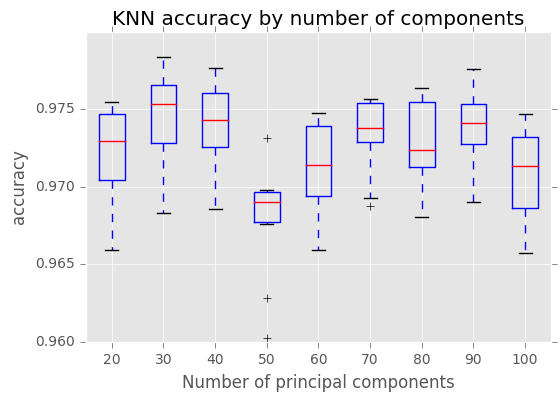

In [136]:
knn_clean = [np.ndarray.tolist(i) for i in knn_scores.values()]
plt.boxplot(knn_clean)
plt.title('KNN accuracy by number of components')
plt.ylabel('accuracy')
plt.xticks(range(1,10), list(range(20, 101, 10)))
plt.xlabel('Number of principal components')
plt.show()

Well, they're all pretty similar; not a huge difference.  But it looks like most of them fared better than the model with 10 components, and 30 components had the highest mean score.  97% accuracy isn't bad with this approach, I think.

I'll try more components with SVC, as well.  There's no real reason to assume that the exact number of principal components will make a difference with that classifier than with KNN output, so I'll just choose n_components=30, instead of re-running the entire range above with the support vector classifier.

In [103]:
pca = PCA(n_components=30)
pca.fit(X)
X_pca30 = pca.transform(X)
test_pca30 = pca.transform(test3)

In [119]:
%%time

svc = svm.SVC(cache_size=1000)
svc5 = cross_val_score(svc, X_pca30, train4.iloc[:, 0].values, cv=10, n_jobs=-1)

Wall time: 1min 53s


In [120]:
print(np.mean(svc5))

0.979928129967


Ok, so coupling PCA with 30 components and SVC is slightly better than KNN.  I think that'll make a reasonable stopping place for this approach; it may be possible to wring slightly more accuracy from these tools, but probably at a cost of significantly more time.

## Part 7: Wrap-Up and Submit

Now: retrain with 30 components using the entire training set, predict test values, and submit.

In [163]:
%%time

svc = svm.SVC(cache_size=1000)
svc6 = svc.fit(X_pca30, train4.iloc[:, 0].values)

Wall time: 20.6 s


In [105]:
%%time

results=svc6.predict(test_pca30)

test4 = test3.copy()
test4['Label'] = pd.Series(results).astype(int)
test4['ImageId'] = test3.index +1
sub = test4[['ImageId','Label']]

sub.to_csv('digit_pca_svc_sub.csv', index=False)

Wall time: 11.5 s


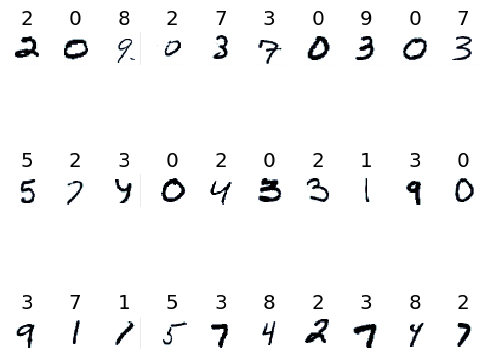

In [101]:
# plot some of the numbers
plt.figure(figsize=(5, 5))
for digit in range(0,30):
    plt.subplot(3,10,digit+1)
    grid_data = test4.iloc[digit,:-2].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r", label=train.iloc[digit,0])
    title = int(test4.iloc[digit,-2])
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Hmm... this one has more errors in the first few digits.  Number 3 returns 8 when it should be 9; number 4 it calls 9 instead of 0 (just like the other models did), but in the second row there are more errors: #13 should probably be 4 but it calls 9, same for #15, #16 should be 3 but it calls 0...

In short, this set of predictions looks like a mess.  Let's see what Kaggle makes of it.

No, that one scored just 75% accuracy after upload.  Something went wrong; better troubleshoot it.  

## Part 8: Something is Amiss

This is exactly the kind of concern that countless machine learning manuals talk about: that your models may not generalize well.  But a 95% accuracy when cross-validating within the train set dropping to 70-75% on the test set?  That's pretty hard to rationalize.

There's something importantly different between the cross-validation score and the test accuracy, when this workflow is applied.  I didn't see this in the previous approaches (random forests and neural networks), so it's sensible to look through the dimensionality reduction and svc performance in greater depth.


## Long Story Short:

I had tried troubleshooting this result further, but the code became a rat's nest of unedifying drivel, so I've removed it below, and will merely summarize the results I found.  First, I tried re-transforming the test data by fitting to the test data, rather than using the fit to the training data, but this caused the accuracy to *decrease* slightly.  Next, I tried decreasing the number of components in PCA to 15, or increasing it to 60 or 200, repeating the fitting of SVC on the new-dimension principal components, and predicting the test data again, but all such predictions were still equally poor.

Then, I re-ran cross_val_score to confirm that the cross-validation scores were still much higher than the test accuracy.  Afterwards, I tried using KNN instead of SVC on the test data; the accuracy improved slightly, but Kaggle judged it as closer to 80%, not the 97% seen with cross_validation.

Finally, I decided that the number of named variables had become unwieldy, and it was becoming difficult to ensure that I was using the right trained model on the right-dimension data, so I scrapped further iterations, started clean with a new notebook, and stepped through the workflow below.  One additional change that I made in doing so was, after having decided that the n_components I wanted to use in PCA was around 30, I repeated checking the parameter space with SVC and PCA using that number specifically, whereas in the results above I had tested these with n_components=10, which may have caused some disagreement with the downstream processing.  The only significant result was that KNN functioned best with n_neighbors=4 and weights='distance'; the optimal C value for the SVC was still the default of 1.

Still, I think it unlikely that this wrinkle caused the mismatch between train and test accuracy.  I think a fresh start was what was needed here; I will copy the code below and re-run, to ensure that the right results can be achieved:

## Part 9: Starting Fresh

In [255]:
%%time

# on the PC:
train = pd.read_csv('C:\\Users\\DMacKellar\\Documents\\Python\\Kaggle\\Digit\\train.csv')

test = pd.read_csv('C:\\Users\\DMacKellar\\Documents\\Python\\Kaggle\\Digit\\test.csv')

# on the Mac:
# train = pd.read_csv('/Users/drew/Documents/Data/R/Kaggle_Digit_Recognizer/train.csv')

# test = pd.read_csv('/Users/drew/Documents/Data/R/Kaggle_Digit_Recognizer/test.csv')

Wall time: 6.51 s


## Rescale the Data

In [256]:
train2 = MaxAbsScaler().fit_transform(train.iloc[:,1:].values)
train3 = pd.DataFrame(data=train2, index=train.index, columns=train.columns[1:])
train = pd.concat([train.iloc[:,0], train3], axis=1, join='inner')
test2 = MaxAbsScaler().fit_transform(test.values)
test = pd.DataFrame(data=test2, index=test.index, columns=test.columns)

## Reduce Dimensionality

In [257]:
pca = PCA(n_components=30)
train_pca = pca.fit_transform(train.iloc[:,1:])
test_pca = pca.transform(test)

## Fit to Train Data Set

In [258]:
%%time

svc2 = svc.fit(train_pca, train.iloc[:, 0].values)
test_svc = svc2.predict(test_pca)

Wall time: 31.3 s


In [260]:
%%time

knn2 = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn3 = knn2.fit(train_pca, train.iloc[:, 0].values)
test_knn = knn3.predict(test_pca)

Wall time: 48.4 s


In [262]:
%%time

train_knn = knn3.predict(train_pca)
train_svc = svc2.predict(train_pca)

Wall time: 1min 20s


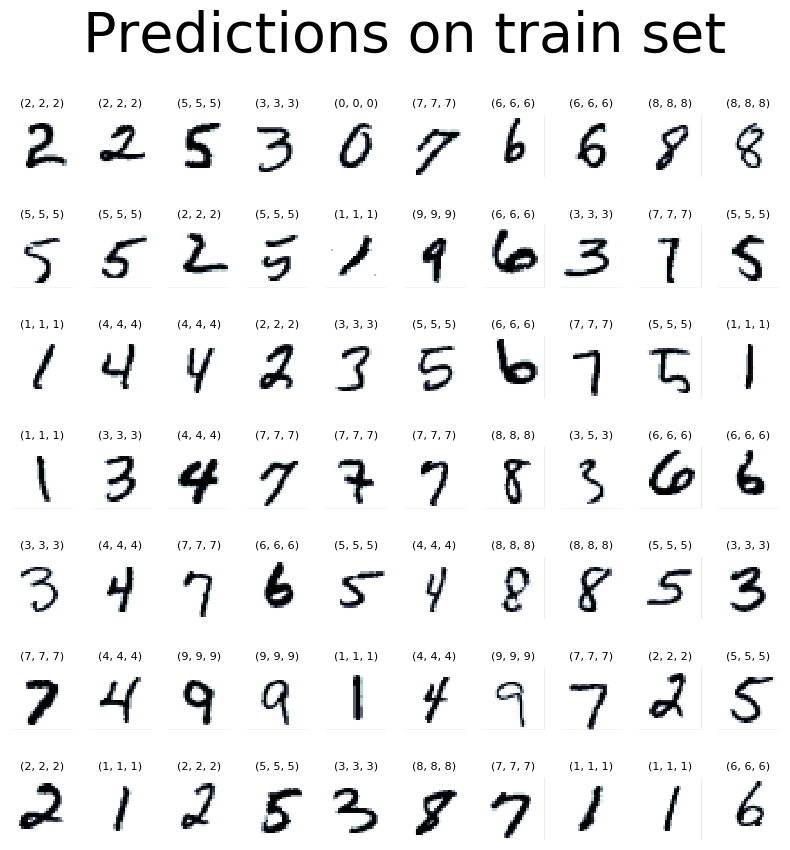

In [263]:
# plot some of the numbers
subplot1 = 1
plt.figure(figsize=(8, 8))
for digit in random.sample(range(len(train)), 70):
    plt.subplot(7,10,subplot1)
    grid_data = train.iloc[digit, 1:].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    title = (train_knn[digit], train_svc[digit], int(train.iloc[digit,0]))
    plt.title(title, fontsize=8)
    plt.xticks([])
    plt.yticks([])
    subplot1 += 1
plt.tight_layout()
plt.text(-280, -320, 'Predictions on train set', fontsize=40)
plt.show()

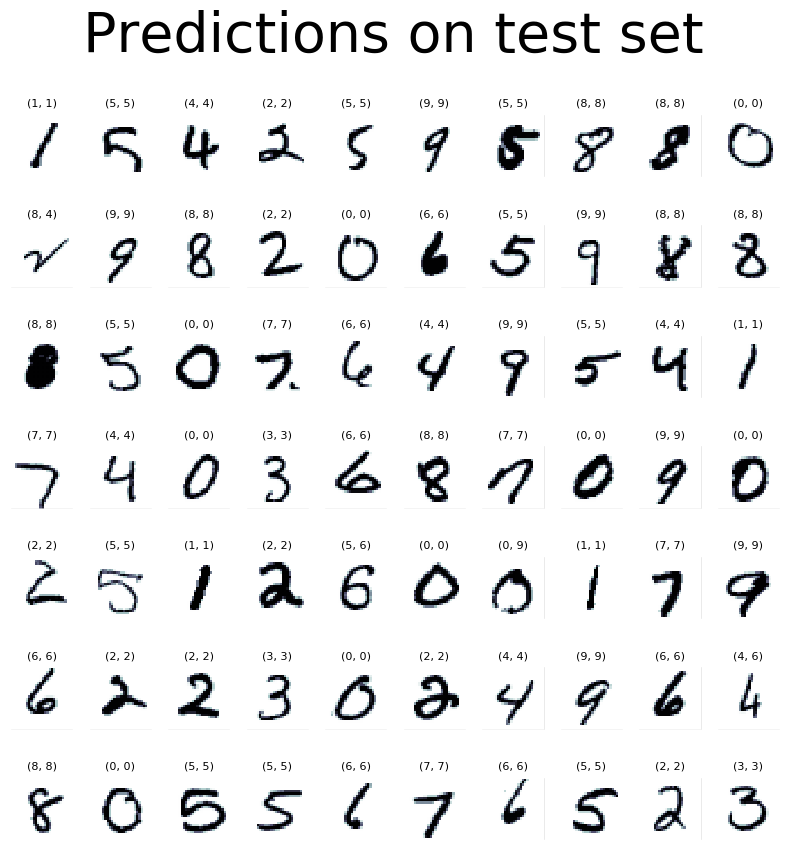

In [264]:
# plot some of the numbers
subplot1 = 1
plt.figure(figsize=(8, 8))
for digit in random.sample(range(len(test)), 70):
    plt.subplot(7,10,subplot1)
    grid_data = test.iloc[digit].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    title = (test_knn[digit], test_svc[digit])
    plt.title(title, fontsize=8)
    plt.xticks([])
    plt.yticks([])
    subplot1 += 1
plt.tight_layout()
plt.text(-280, -320, 'Predictions on test set', fontsize=40)
plt.show()

There.  That is clearly much better.  Some of these digits are still problematic, but I don't see such poor performance from the models.  I'll write this to a submission file and see what Kaggle thinks.

In [265]:
%%time

results=svc2.predict(test_pca)

test3 = test.copy()
test3['Label'] = pd.Series(results).astype(int)
test3['ImageId'] = test3.index +1
sub = test3[['ImageId','Label']]

Wall time: 11.3 s


In [267]:
test3.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,Label,ImageId
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,5


In [268]:
sub.to_csv('digit_pca_svc_sub.csv', index=False)

"Your submission scored 0.97814, which is an improvement of your previous score of 0.97114. Great job!"

Ok, that's a relief.  I'll leave the above messiness in this notebook, just to remind myself that sometimes unexpected troubleshooting may be required, and an efficient solution may be to simplify and start over.

Combined with my experience in the other two notebooks so far (applying random forests and basic neural networks), I'd say I've done almost all I'm interested in with this data set.  There is one more approach I'd like to try before moving on, however: it seems that the top of the Kaggle leaderboard for the digit_recognizer is choked with people who've gotten perfect or near-perfect accuracy using convolutional neural networks, typically using keras or tensorflow as the base.  I intend to try that in one more notebook, when I get time.